In [3]:
from halotools.sim_manager import CachedHaloCatalog, FakeSim
from halotools.empirical_models import PrebuiltHodModelFactory, Zheng07Cens, Zheng07Sats, TrivialPhaseSpace, NFWPhaseSpace, HodModelFactory
from halotools.mock_observables import return_xyz_formatted_array,wp
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import time
from multiprocessing import Pool, cpu_count
import emcee
import corner
from Corrfunc.theory.wp import wp
from numpy.linalg import inv
import scipy.optimize as op
from scipy.stats import chi2
import scipy.stats as stats
import random
import warnings
warnings.filterwarnings("ignore")
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
from scipy.special import gamma
from scipy.stats import chisquare, gaussian_kde,skewnorm,expon
from sklearn.neighbors import NearestNeighbors, KDTree

In [1]:
fname = "zehavi_smdpl_mvir_m20_test.h5"
wp_out_file = None#'zehavi_smdpl_mvir_m19_wp.npy'
dname ='zehavi_data_file_20'
param = 'mvir'
threshold = 20
ext = 'mvir_m20.npz'

In [4]:
if '21' in dname:
    import zehavi_data_file_21
    wp_ng_vals = zehavi_data_file_21.get_wp()[0:12]
    bin_edges = zehavi_data_file_21.get_bins()[0:12]
    cov_matrix = zehavi_data_file_21.get_cov()[0:11,0:11]
    err = np.array([cov_matrix[i,i] for i in range(len(cov_matrix))])
    invcov = inv(cov_matrix)
    ng_cov = 0.000005
    bin_cen = (bin_edges[1:]+bin_edges[:-1])/2.
if '19' in dname:
    print('19')
    import zehavi_data_file_19
    wp_ng_vals = zehavi_data_file_19.get_wp()[0:12]
    bin_edges = zehavi_data_file_19.get_bins()[0:12]
    cov_matrix = zehavi_data_file_19.get_cov()[0:11,0:11]
    err = np.array([cov_matrix[i,i] for i in range(len(cov_matrix))])    
    bin_cen = (bin_edges[1:]+bin_edges[:-1])/2.
    invcov = inv(cov_matrix)
    ng_cov = 0.000068
if '20' in dname:
    print('20')
    import zehavi_data_file_20
    wp_ng_vals = zehavi_data_file_20.get_wp()[0:12]
    bin_edges = zehavi_data_file_20.get_bins()[0:12]
    cov_matrix = zehavi_data_file_20.get_cov()[0:11,0:11]
    err = np.array([cov_matrix[i,i] for i in range(len(cov_matrix))])    
    bin_cen = (bin_edges[1:]+bin_edges[:-1])/2.
    invcov = inv(cov_matrix)
    ng_cov = 0.00007
if 'guo' in dname:
    wp_ng_vals = guo_data_file.get_wp()
    bin_edges = guo_data_file.get_bins()
    cov_matrix = guo_data_file.get_cov()
    err = np.array([cov_matrix[i,i] for i in range(len(cov_matrix))])
    bin_cen = (bin_edges[1:]+bin_edges[:-1])/2.

if 'mock' in dname:
    wp_ng_vals = mock_data_2.get_wp()
    bin_edges = mock_data_2.get_bin_edges()
    cov_matrix = mock_data_2.get_cov()
    err = np.array([cov_matrix[i,i] for i in range(len(cov_matrix))])
    bin_cen = (bin_edges[1:]+bin_edges[:-1])/2.

20


In [5]:
files = [fname]
#files = [fname4,fname5]
s = []
log_prob_s = []
wps = []
for f in files: 
    reader = emcee.backends.HDFBackend(f, read_only=True)
    s.append(reader.get_chain(discard=1000, flat=False, thin=1))
    log_prob_s.append(reader.get_log_prob(discard=1000, flat=False, thin=1))
    wps.append(reader.get_blobs(discard=1000))
print(reader.iteration)


100000


In [6]:
if len(files)>1:
    print('greater')
    samples = s[0]
    log_prob_samples = log_prob_s[0]
    wp_samples = wps[0]
    for i in range(len(files)):
        if i+1 < len(s):
            samples = np.concatenate((samples,s[i+1]))
            log_prob_samples = np.concatenate((log_prob_samples,log_prob_s[i+1]))
            wp_samples = np.concatenate((wp_samples,wps[i+1]))
else:
    samples = s[0]
    log_prob_samples = log_prob_s[0]
    wp_samples = wps[0]
min_chi2_loc = np.where(-2*log_prob_samples==(-2*log_prob_samples.max()))
#best_wp = wp_samples[min_chi2_loc][0]
best_chi2 = (-2*log_prob_samples[min_chi2_loc])[0]


# Nearest Neighbor

In [9]:
dsamples = samples[:,:20,:][::50,:]
print(dsamples.shape)
dsamples=samples[:,:20,:][::50,:].reshape(39600,5)
print(dsamples.shape)

(1980, 20, 5)
(39600, 5)


In [31]:
####Prepare data for nearest neighbor search
print('Median values:')
print(' logMvirmin, sigma_logMvir, alpha, logMvir_0, logMvir1')
params_median = np.median(dsamples, axis=0)
params_std = np.std(dsamples, axis=0)
print('  ', params_median[[0, 1, 2, 3, 4]])
print('+-', params_std[[0, 1, 2, 3, 4]])
print()

# Find the best-fit parameters in segments of the chain
params_1_sigma_range = (np.percentile(dsamples, 84, axis=0) - np.percentile(dsamples, 16, axis=0))/2

print('1-sigma range:')
print(' logMvirmin, sigma_logMvir, alpha, logMvir_0, logMvir1')
print('  ', params_1_sigma_range[[0, 1, 2, 3, 4]])

Median values:
 logMvirmin, sigma_logMvir, alpha, logMvir_0, logMvir1
   [11.91203134  0.20067223  1.0531194  12.01196907 13.22761402]
+- [0.07760855 0.20032835 0.0423405  0.65467406 0.04901371]

1-sigma range:
 logMvirmin, sigma_logMvir, alpha, logMvir_0, logMvir1
   [0.04492674 0.17546164 0.04369355 0.65034464 0.05023622]


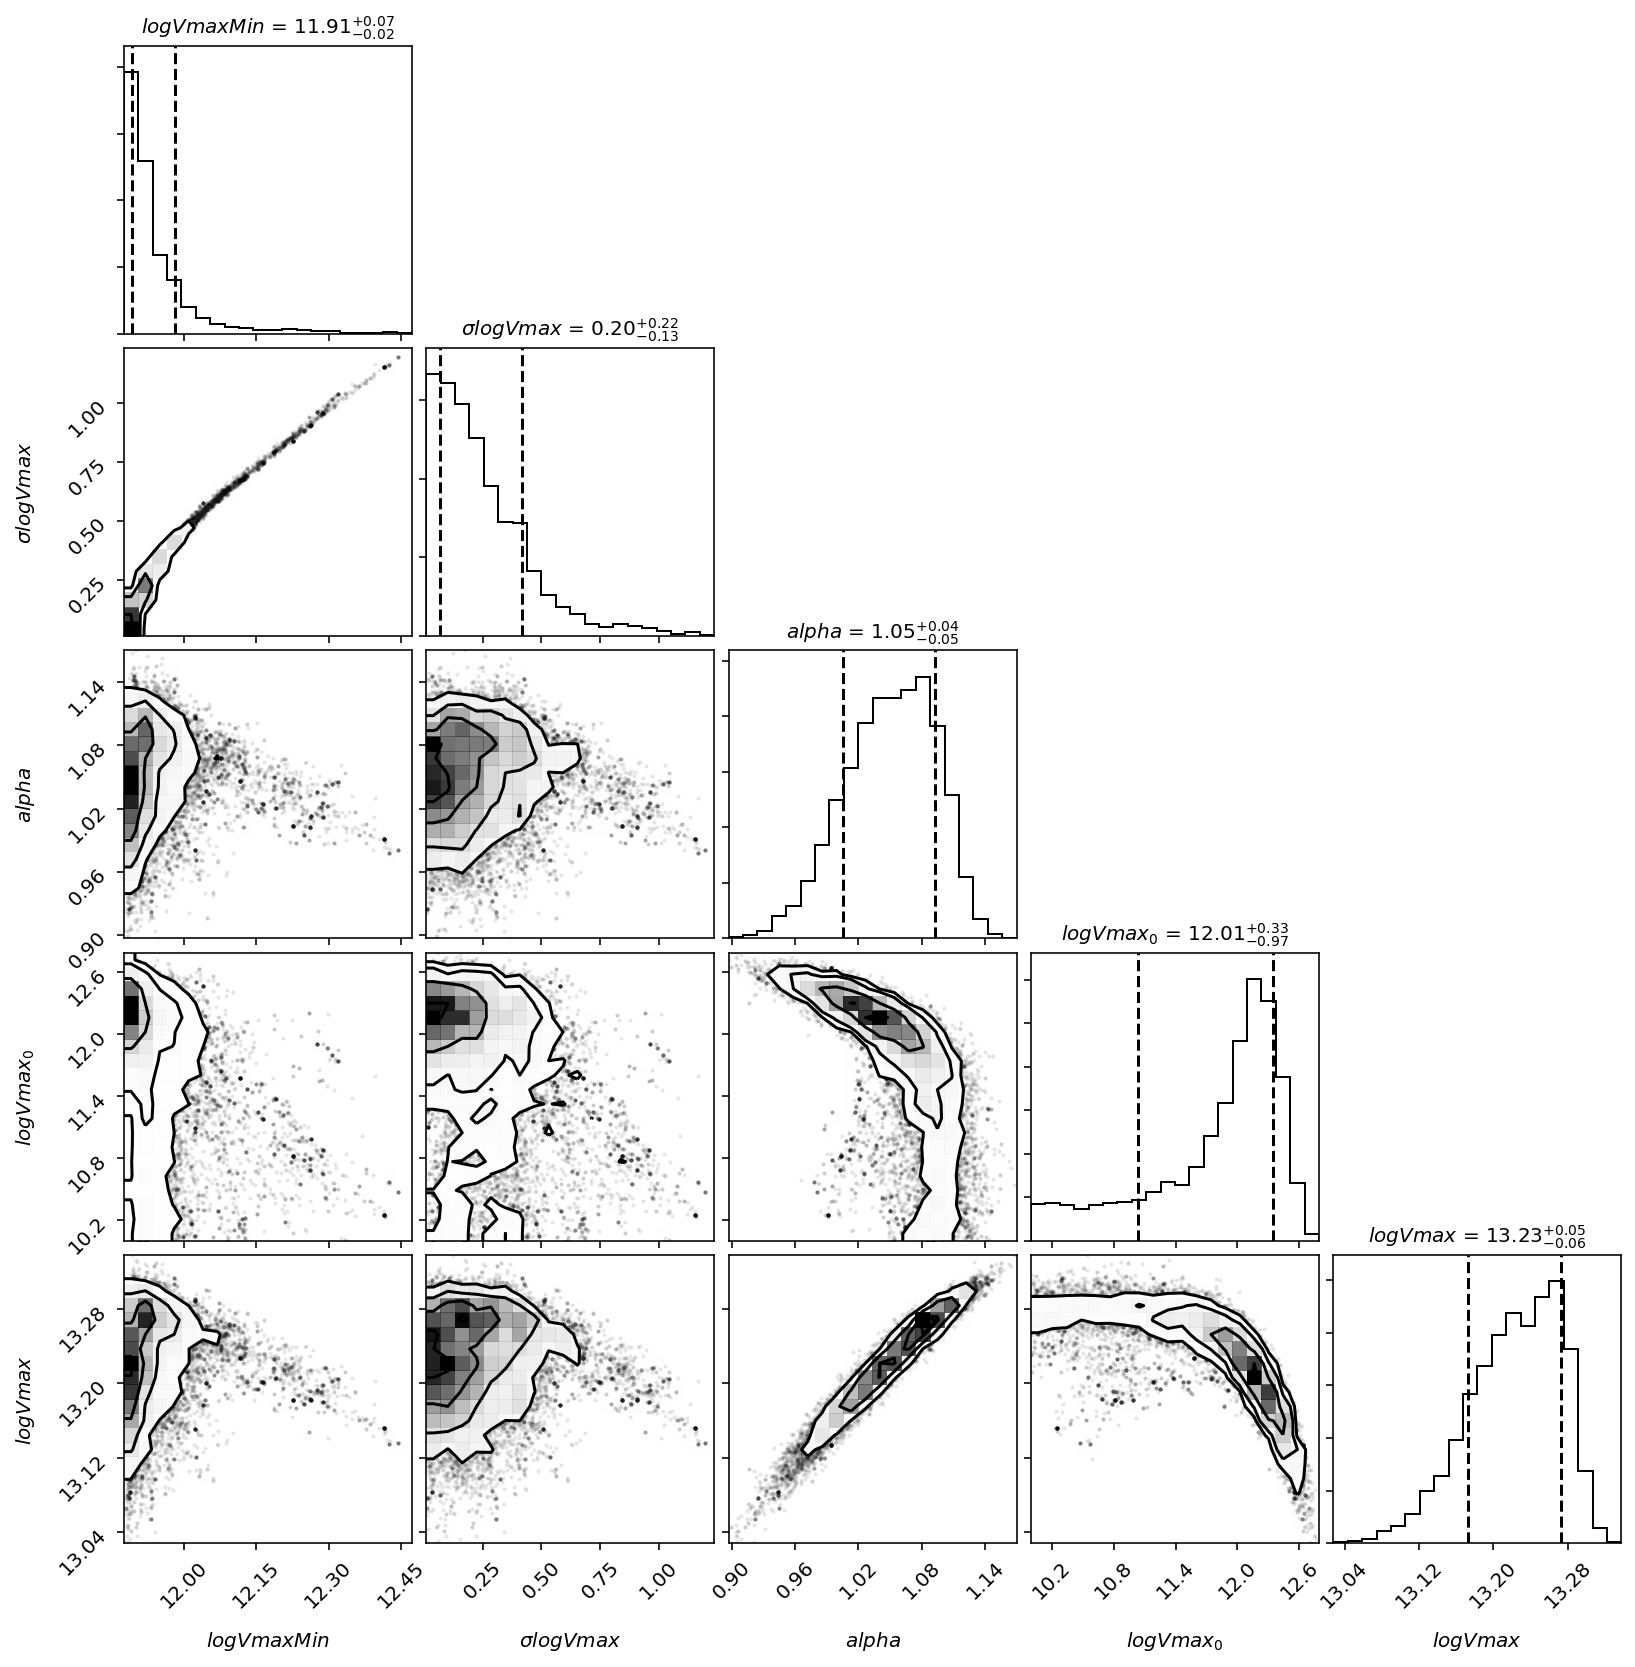

In [32]:
ndim=5
fig = corner.corner(dsamples.reshape((-1,ndim)),
        labels=["$logVmaxMin$", "${\sigma}logVmax$", "$alpha$", "$logVmax_0$", "$logVmax$"],
        show_titles=True,title_kwargs={"fontsize": 10},quantiles=(0.16, 0.84),bins=20)#, levels=(1-np.exp(-0.5),))

In [33]:
data = dsamples[:, :6]

# Reflect against hard prior boundaries
# sigma_logM

data_new = np.copy(data)
data_new[:, 1] = -data_new[:, 1]
data = np.concatenate([data, data_new], axis=0)

data_new = np.copy(data)
data_new[:, 3] = -data_new[:, 3]
data = np.concatenate([data, data_new], axis=0)

# rescaling the dimensions
data_rescale = data/params_1_sigma_range[None, :6]

# Find the distance to the n-th nearest neighbor
neigh = NearestNeighbors(n_neighbors=501, radius=np.inf, algorithm='kd_tree')
neigh.fit(data_rescale)
dist, _ = neigh.kneighbors(data_rescale, return_distance=True)

# Remove the reflected points
maxdist = np.max(dist, axis=1)
idx_best = np.argsort(maxdist)
mask = idx_best < len(dsamples)
print(np.sum(mask)/len(idx_best))
idx_best = idx_best[mask]

# select the top n_best points
n_best = 500
idx_best = idx_best[:n_best]
print(dsamples[idx_best][0])

0.25
[11.8909989   0.06608522  1.02768082 12.22343282 13.19501586]


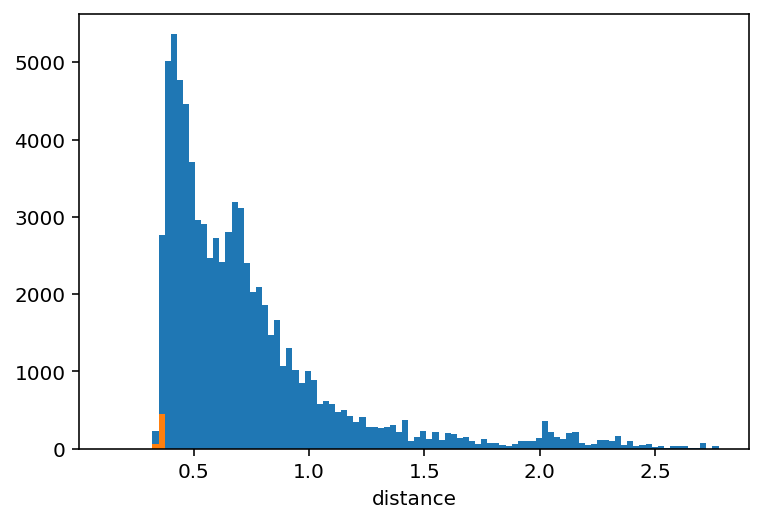

In [34]:
plt.hist(maxdist, 100, range=(np.min(maxdist)-0.2, np.percentile(maxdist, 99)))
plt.hist(maxdist[idx_best], 100, range=(np.min(maxdist)-0.2, np.percentile(maxdist, 99)))
plt.xlabel('distance')
plt.show()


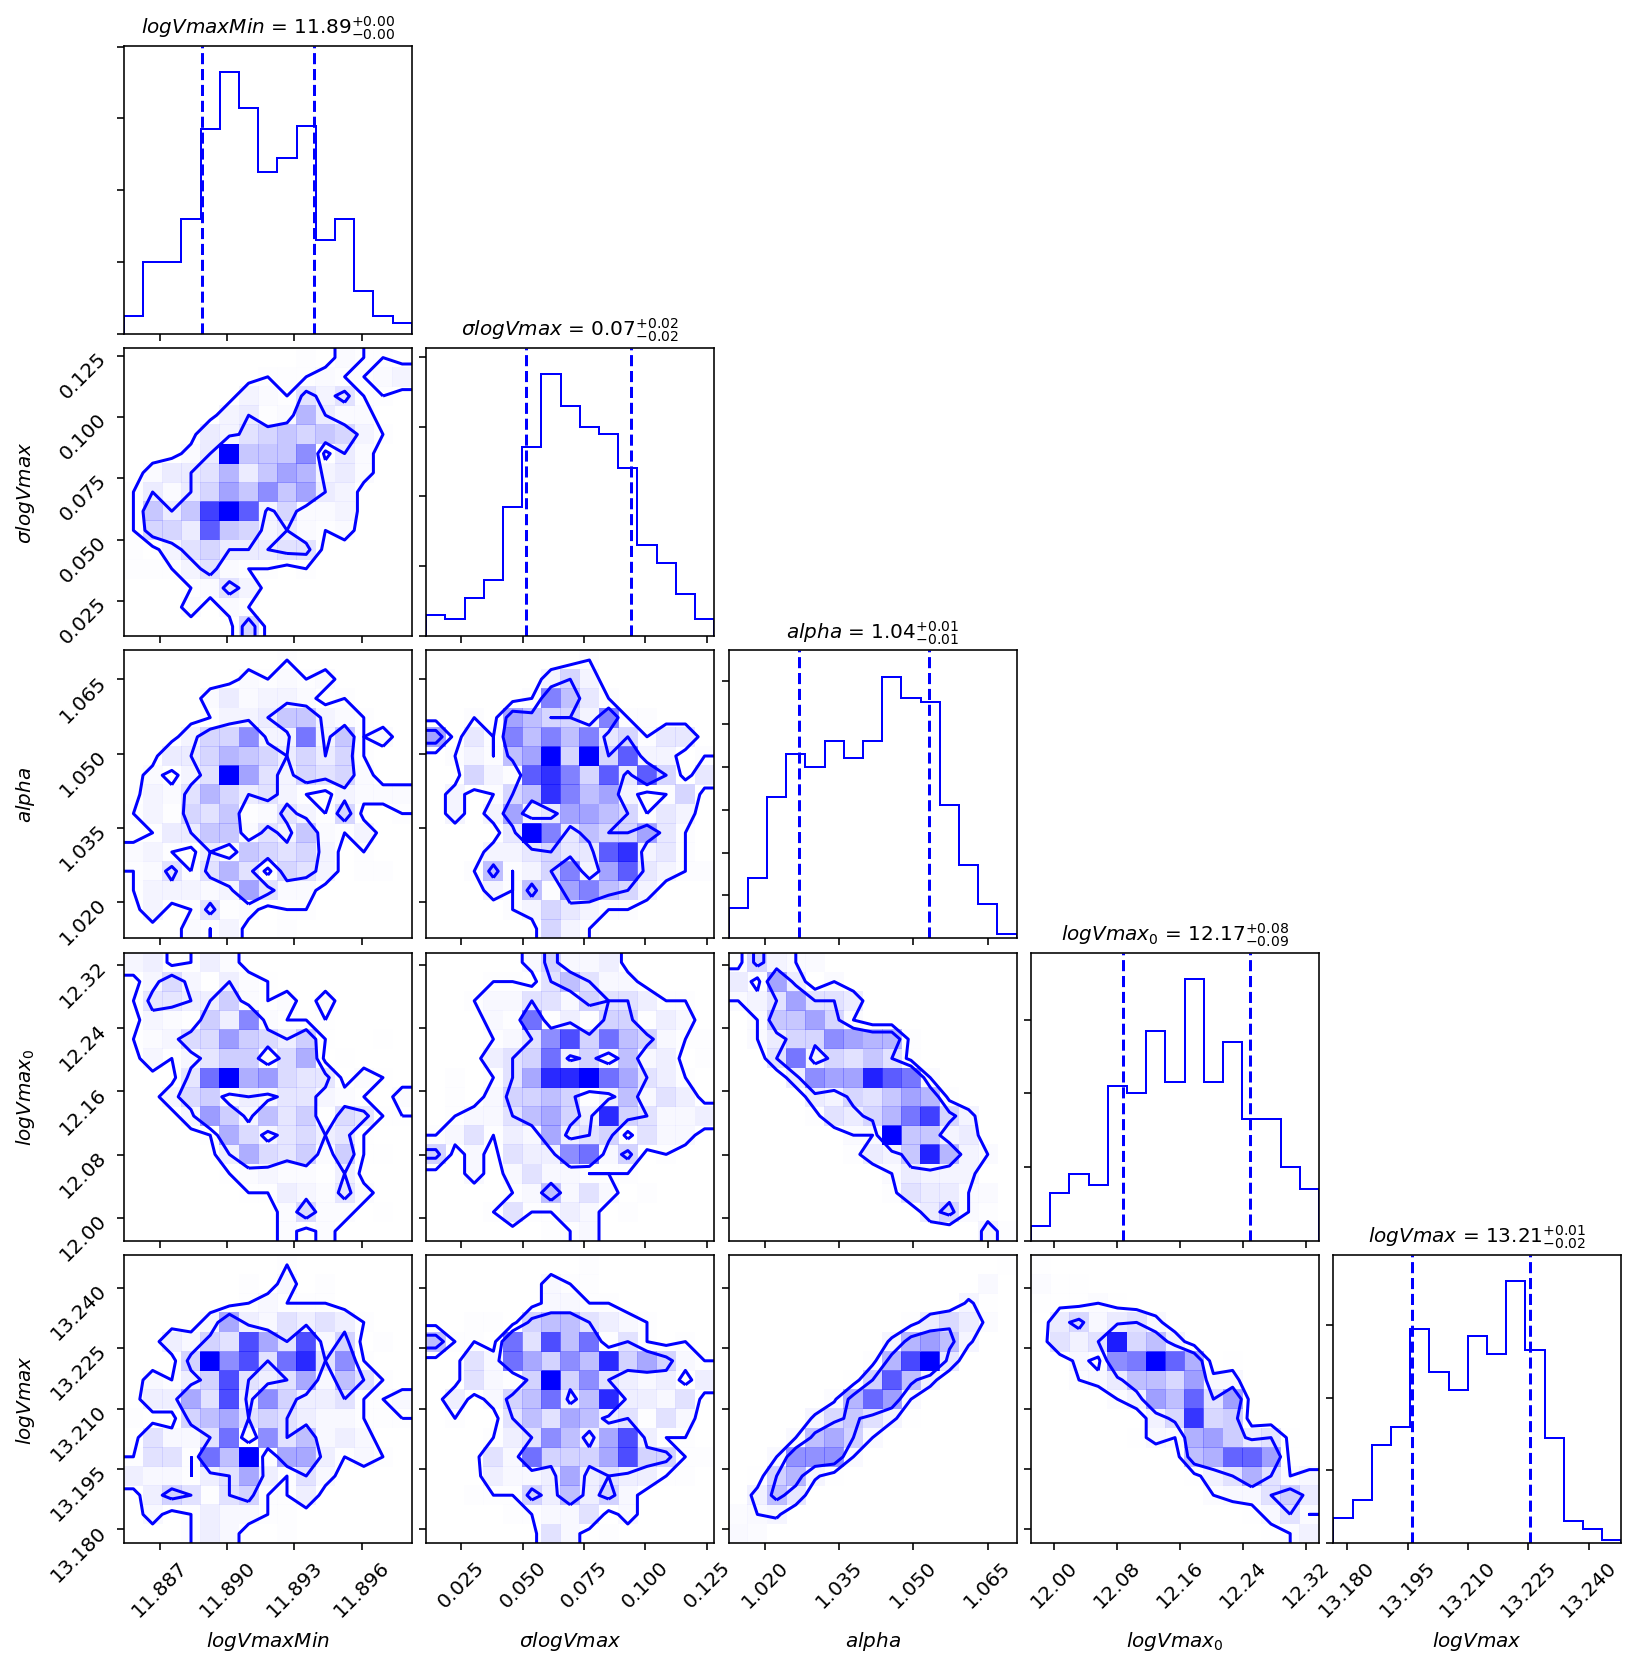

In [35]:
ndim=5
fig = corner.corner(dsamples[idx_best].reshape((-1,ndim)),
        labels=["$logVmaxMin$", "${\sigma}logVmax$", "$alpha$", "$logVmax_0$", "$logVmax$"],
        show_titles=True,title_kwargs={"fontsize": 10},levels=(0.68, 0.95,),plot_datapoints=False,
        fill_contours=False,plot_density=True,quantiles=(0.16, 0.84), color='b',bins=15)#, levels=(1-np.exp(-0.5),))

Find average Chi2

In [12]:
if param == 'mvir':
    print('mvir')
    cens_occ_model = Zheng07Cens(threshold=threshold)
    cens_prof_model = TrivialPhaseSpace()

    sats_occ_model =  Zheng07Sats(modulate_with_cenocc=True,threshold=threshold)
    sats_prof_model = NFWPhaseSpace()
else:
    print('vmax')
    cens_occ_model = Zheng07Cens(prim_haloprop_key = 'halo_vmax',threshold=threshold)
    cens_prof_model = TrivialPhaseSpace()

    sats_occ_model =  Zheng07Sats(prim_haloprop_key = 'halo_vmax', modulate_with_cenocc=True,threshold=threshold)
    sats_prof_model = NFWPhaseSpace()
    
#halocat = CachedHaloCatalog(simname='bolshoi',redshift = 0.0)
#halocat = CachedHaloCatalog(fname = '/Users/lmezini/.astropy/cache/halotools/halo_catalogs/bolplanck/rockstar/hlist_1.00231.list.halotools_v0p4.hdf5',update_cached_fname = True)
#halocat = CachedHaloCatalog(fname = '/Users/lmezini/Downloads/hlist_1.00231.list.halotools_v0p1.hdf5',update_cached_fname = True)
halocat = CachedHaloCatalog(fname='/Users/lmezini/.astropy/cache/halotools/halo_catalogs/SMDPL/rockstar/2019-07-03-18-38-02-9731.dat.my_cosmosim_halos.hdf5')
halocat.redshift = 0.
pi_max = 60.
Lbox = 400.
model_instance = HodModelFactory(centrals_occupation = cens_occ_model, centrals_profile = cens_prof_model, 
                                 satellites_occupation = sats_occ_model, satellites_profile = sats_prof_model)

mvir


In [101]:
nrepeat=100

In [21]:
nthreads = 4

# number of repeats
nrepeat = 1

lnlike_all = np.zeros((len(idx_best), nrepeat))

time_last = time.time()
for index in range(1):#len(idx_best)):
    
    model_instance.param_dict['logMmin'] = dsamples[idx_best[index]][0]
    model_instance.param_dict['sigma_logM'] = dsamples[idx_best[index]][1]
    model_instance.param_dict['alpha'] = dsamples[idx_best[index]][2]
    model_instance.param_dict['logM0'] = dsamples[idx_best[index]][3]
    model_instance.param_dict['logM1'] = dsamples[idx_best[index]][4]

    # Repeatedly populate galaxies and average lnL
    for repeat_index in range(nrepeat):

        try:
            model_instance.mock.populate()
        except:
            model_instance.populate_mock(halocat)

        number_gal = len(model_instance.mock.galaxy_table)
        
        pos = return_xyz_formatted_array(model_instance.mock.galaxy_table['x'], 
                                        model_instance.mock.galaxy_table['y'],
                                        model_instance.mock.galaxy_table['z'],period = Lbox)
        x = pos[:,0]
        y = pos[:,1]
        z = pos[:,2]
        velz = model_instance.mock.galaxy_table['vz']
        pos_zdist = return_xyz_formatted_array(x,y,z, period = Lbox, 
                        velocity=velz, velocity_distortion_dimension='z')

        mod = wp(Lbox,pi_max,1,bin_edges,pos_zdist[:,0],pos_zdist[:,1],pos_zdist[:,2],
                    verbose=True)
        model_wp = mod['wp']
        # log likelihood from wprp
        wp_dev = model_wp - wp_ng_vals[1:len(wp_ng_vals)]
        wplike = -0.5*np.dot(np.dot(wp_dev, invcov), wp_dev)

        # log likelihood from number density
        ngal = number_gal/(model_instance.mock.Lbox[0]**3)
        ng_theory_error = ngal/np.sqrt(number_gal)
        nglike = -0.5*((ngal-wp_ng_vals[0])**2/(ng_cov**2))#+ng_theory_error**2))

        lnlike_all[index, repeat_index] = np.exp(wplike + nglike)
        print(np.log(lnlike_all))
        #####################################################################
    
    time_now = time.time()
    print('{}  {:.0f} sec'.format(index, time_now-time_last))
    time_last = time_now

#np.savez_compressed('best_fit_lnprob_vmax_m20.npz',#.format(zbin_index), 
#                    idx=idx_best, lnlike_all=lnlike_all)

In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.112 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.202 secs


[[-6.53235779]
 [       -inf]
 [       -inf]
 [       -inf]
 [       -inf]
 [       -inf]
 [       -inf]
 [       -inf]
 [       -inf]
 [       -inf]
 [       -inf]
 [       -inf]
 [       -inf]
 [       -inf]
 [       -inf]
 [       -inf]
 [       -inf]
 [       -inf]
 [       -inf]
 [       -inf]
 [       -inf]
 [       -inf]
 [       -inf]
 [       -inf]
 [       -inf]
 [       -inf]
 [       -inf]
 [       -inf]
 [       -inf]
 [       -inf]
 [       -inf]
 [       -inf]
 [       -inf]
 [       -inf]
 [       -inf]
 [       -inf]
 [       -inf]
 [       -inf]
 [       -inf]
 [       -inf]
 [       -inf]
 [       -inf]
 [       -inf]
 [       -inf]
 [       -inf]
 [       -inf]
 [       -inf]
 [       -inf]
 [       -inf]
 [       -inf]
 [       -inf]
 [       -inf]
 [       -inf]
 [       -inf]
 [       -inf]
 [       -inf]
 [       -inf]
 [       -inf]
 [       -inf]
 [       -inf]
 [       -inf]
 [       -inf]
 [       -inf]
 [       -inf]
 [       -inf]
 [       -inf]
 [       -

In [102]:
results = np.load('best_fit_lnprob_'+ext)#_vmax_m21_2.npz')
lnlike_all = results['lnlike_all']
nrepeat=100

In [103]:
def hlmean(data, multiplier=None, verbose=True):
    ndata = len(data)
    if ndata==0 and verbose:
        print('H-L mean: empty array!!!')
    if ndata < 200:
        pairmean = np.zeros(int(ndata*(ndata+1)/2))
        index = 0
        for i in range(ndata):
            for j in range(i,ndata):
                pairmean[index] = (data[i]+data[j])/2
                index += 1
    else:
        if multiplier==None:
            nsamp = 200 * ndata
        else:
            nsamp = multiplier * ndata
        idx = np.floor(np.random.rand(nsamp,2)*ndata)
        idx = idx.astype(np.int64,copy=False)
        pairmean = np.sum(data[idx],axis=1)/2.
    return(np.median(pairmean))

In [104]:
lnlike_mean = np.mean(lnlike_all,axis=1)

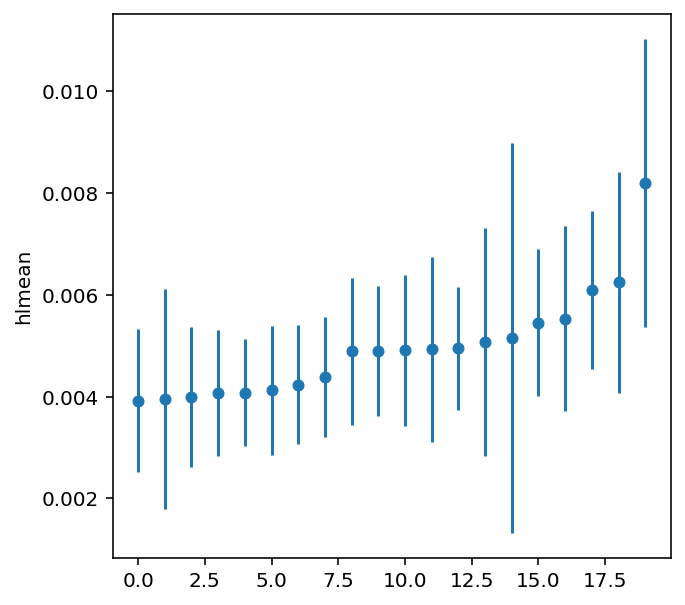

In [105]:
plt.figure(figsize=(5, 5))
plt.errorbar(np.arange(20), lnlike_mean[np.argsort(np.mean(lnlike_all,axis=1))[-20:]], 
             yerr=np.std(lnlike_all[np.argsort(np.mean(lnlike_all,axis=1))[-20:]], axis=1)/np.sqrt(nrepeat), 
             markersize=10, fmt='x', marker='.')
plt.ylabel('hlmean')
# plt.ylabel('mean')
plt.show()

In [37]:
# Top 10 points
idx_best_10 = idx_best[np.argsort(lnlike_mean)[-10:]]
params_best = dsamples[idx_best_10[0]]
params_best_plus = np.percentile(dsamples, 84, axis=0) - params_best
params_best_minus = params_best - np.percentile(dsamples, 16, axis=0)
print('Best-fit values:')
print('  [alpha  logM1  sigma_logM  logM0  logMmin  pzerr_rescale  bias]')
print('  ', params_best[[0, 1, 2, 3, 4]])
print(' +', params_best_plus[[0, 1, 2, 3, 4]])
print(' -', params_best_minus[[0, 1, 2, 3, 4]])

NameError: name 'lnlike_mean' is not defined

In [ ]:
nthreads = 4

# number of repeats

nrepeat = 1

lnlike_all = np.zeros((len(idx_best_10), nrepeat))

time_last = time.time()
for index in range(len(idx_best_10)):
    model_instance.param_dict['logMmin'] = dsamples[idx_best[index]][0]
    model_instance.param_dict['sigma_logM'] = dsamples[idx_best[index]][1]
    model_instance.param_dict['alpha'] = dsamples[idx_best[index]][2]
    model_instance.param_dict['logM0'] = dsamples[idx_best[index]][3]
    model_instance.param_dict['logM1'] = dsamples[idx_best[index]][4]

    # Repeatedly populate galaxies and average lnL
    for repeat_index in range(nrepeat):

        try:
            model_instance.mock.populate()
        except:
            model_instance.populate_mock(halocat)

        number_gal = len(model_instance.mock.galaxy_table)
        
        pos = return_xyz_formatted_array(model_instance.mock.galaxy_table['x'], 
                                        model_instance.mock.galaxy_table['y'],
                                        model_instance.mock.galaxy_table['z'],period = Lbox)
        x = pos[:,0]
        y = pos[:,1]
        z = pos[:,2]
        velz = model_instance.mock.galaxy_table['vz']
        pos_zdist = return_xyz_formatted_array(x,y,z, period = Lbox,
                                                velocity=velz, velocity_distortion_dimension='z')

        mod = wp(Lbox,pi_max,1,bin_edges,pos_zdist[:,0],pos_zdist[:,1],pos_zdist[:,2], verbose=True)
        model_wp = mod['wp']
        # log likelihood from wprp
        wp_dev = model_wp - wp_ng_vals[1:len(wp_ng_vals)]
        wplike = -0.5*np.dot(np.dot(wp_dev, invcov), wp_dev)

        # log likelihood from number density
        ngal = number_gal/(model_instance.mock.Lbox[0]**3)
        ng_theory_error = ngal/np.sqrt(number_gal)
        nglike = -0.5*((ngal-wp_ng_vals[0])**2/(ng_cov**2+ng_theory_error**2))

        lnlike_all[index, repeat_index] = (wplike + nglike)

        #####################################################################
    
    time_now = time.time()
    print('{}  {:.0f} sec'.format(index, time_now-time_last))
    time_last = time_now

np.savez_compressed('top10_best_fit_lnprob_zbin.npz',#.format(zbin_index), 
                    idx=idx_best_10, lnlike_all=lnlike_all)

2

3434


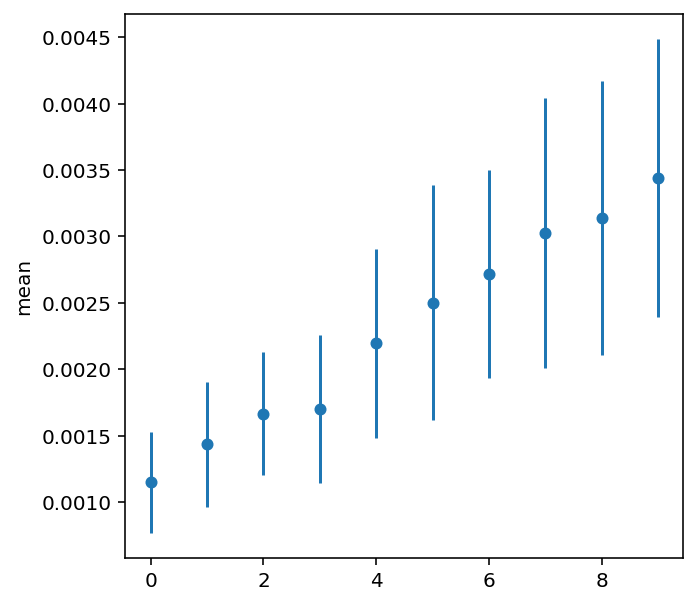

In [107]:
results = np.load('top10_best_fit_lnprob_'+ext)#vmax_m21_2.npz')#.format(zbin_index))
lnlike_all = results['lnlike_all']

np.random.seed(53)
#lnlike_hlmean = np.array([hlmean(lnlike_all[index], multiplier=50000) for index in range(len(lnlike_all))])
lnlike_mean = np.mean(lnlike_all, axis=1)
#print(np.argsort(lnlike_hlmean)[-1])
print(np.argsort(lnlike_mean)[-1])
print()

idx_single_best = idx_best_10[np.argsort(lnlike_mean)[-1]]
print(idx_single_best)

plt.figure(figsize=(5, 5))
plt.errorbar(np.arange(len(lnlike_mean)), lnlike_mean[np.argsort(lnlike_mean)], 
             yerr=np.std(lnlike_all[np.argsort(lnlike_mean)], axis=1)/np.sqrt(nrepeat), 
             markersize=10, fmt='x', marker='.')
# plt.xlabel('mean')
plt.ylabel('mean')
plt.show()

In [108]:
params_best = dsamples[idx_single_best]
params_best_plus = np.percentile(dsamples, 84, axis=0) - params_best
params_best_minus = params_best - np.percentile(dsamples, 16, axis=0)
print('Best-fit values:')
print('  [alpha  logM1  sigma_logM  logM0  logMmin  pzerr_rescale  bias]')
print('  ', params_best[[0, 1, 2, 3, 4]])
print(' +', params_best_plus[[0, 1, 2, 3, 4]])
print(' -', params_best_minus[[0, 1, 2, 3, 4]])

Best-fit values:
  [alpha  logM1  sigma_logM  logM0  logMmin  pzerr_rescale  bias]
   [2.46079021 0.07870371 2.17427499 2.52490904 2.57942088]
 + [0.03158629 0.07876167 0.8609205  0.09389796 0.19508274]
 - [0.00596302 0.02553445 0.46250199 0.34893211 0.13641202]


In [109]:
# number of repeats
nrepeat = 1

# Initialize arrays
lnlike_all = np.zeros((1, nrepeat))
model_wp_all = np.zeros((1, nrepeat, len(bin_cen)))
number_gal_all = np.zeros((1, nrepeat))

In [74]:
nthreads = 4

for index in [0]:
    
    print(index)
    model_instance.param_dict['logMmin'] = dsamples[idx_best[index]][0]
    model_instance.param_dict['sigma_logM'] = dsamples[idx_best[index]][1]
    model_instance.param_dict['alpha'] = dsamples[idx_best[index]][2]
    model_instance.param_dict['logM0'] = dsamples[idx_best[index]][3]
    model_instance.param_dict['logM1'] = dsamples[idx_best[index]][4]

    # Repeatedly populate galaxies and average lnL
    for repeat_index in range(nrepeat):

        try:
            model_instance.mock.populate()
        except:
            model_instance.populate_mock(halocat)

        number_gal = len(model_instance.mock.galaxy_table)
        
        pos = return_xyz_formatted_array(model_instance.mock.galaxy_table['x'], 
                                        model_instance.mock.galaxy_table['y'],
                                        model_instance.mock.galaxy_table['z'],period = Lbox)
        x = pos[:,0]
        y = pos[:,1]
        z = pos[:,2]
        velz = model_instance.mock.galaxy_table['vz']
        pos_zdist = return_xyz_formatted_array(x,y,z, period = Lbox, 
                        velocity=velz, velocity_distortion_dimension='z')

        mod = wp(Lbox,pi_max,1,bin_edges,pos_zdist[:,0],pos_zdist[:,1],pos_zdist[:,2],
                    verbose=True)
        model_wp = mod['wp']
        # log likelihood from wprp
        wp_dev = model_wp - wp_ng_vals[1:len(wp_ng_vals)]
        wplike = -0.5*np.dot(np.dot(wp_dev, invcov), wp_dev)

        # log likelihood from number density
        ngal = number_gal/(model_instance.mock.Lbox[0]**3)
        ng_theory_error = ngal/np.sqrt(number_gal)
        nglike = -0.5*((ngal-wp_ng_vals[0])**2/(ng_cov**2+ng_theory_error**2))

        lnlike_all[index, repeat_index] = (wplike + nglike)

        #####################################################################
    
    #time_now = time.time()
    #print('{}  {:.0f} sec'.format(index, time_now-time_last))
    #time_last = time_now
    
np.savez_compressed('single_best_mock_results_zbin.npz',#_{}.npz'.format(zbin_index), 
                    lnlike_all=lnlike_all, bin_edges=bin_edges,
                    model_wp_all=model_wp_all, number_gal_all=number_gal_all)

0


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 38,38,6.  Time taken =   0.022 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.384 secs


In [110]:
results = np.load('single_best_mock_results_'+ext)#mvir_m21.npz')#_{}.npz'.format(zbin_index))
lnlike_all = results['lnlike_all']
print('mean likelihood: {}'.format(np.mean(lnlike_all)))
print('chi2: {}'.format(np.log(np.mean(lnlike_all))/-2))

mean likelihood: 0.0021847392677955303
chi2: 3.063129392897398


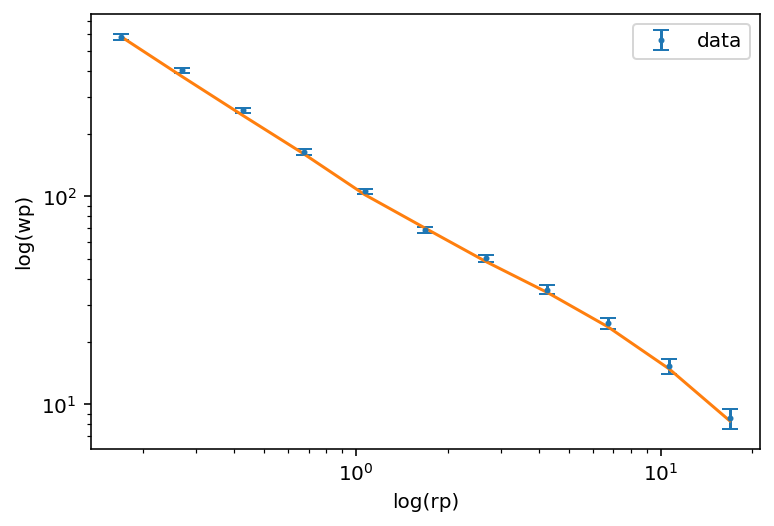

In [76]:
plt.errorbar(bin_cen,wp_ng_vals[1:len(wp_ng_vals)],yerr=np.sqrt(err),fmt='o',markersize=2,capsize=4,label='data')
plt.plot(bin_cen,mod['wp'])
plt.yscale('log')
plt.xscale('log')
#plt.xlim(1e-1,1e2)
plt.legend()
plt.xlabel('log(rp)')
plt.ylabel('log(wp)')
plt.show()